# Recreating Pixel Maps with static pixels in percentile bins

In [1]:
%matplotlib inline

from matplotlib.pyplot import subplots, savefig
import richardsplot as rplot

from utilities.analysis import plotting
from utilities.ccd import CCD
from utilities.containers import *
from utilities.conversions import magToFlux

In [2]:
cmap = rplot.palettable.colorbrewer.diverging.PuOr_11.mpl_colormap

In [3]:
!pwd
!mkdir plots/c08/

/home/jackeline/Research/k2_pipeline/CARMA
mkdir: cannot create directory ‘plots/c08/’: File exists


# Load Data hdf5 file --example using C8 M10.1

In [4]:
pixmapfile = "/media/jackeline/UUI/PixelMaps/K2_target_pixels.hdf5"

#  Run the Pixel Map Generator

In [5]:
ccd = CCD(module=10, channel=1, field='FLUX', campaign=8)
cont = PixelMapContainer.from_hdf5(pixmapfile, ccd)
cont.save(pixmapfile)
gen = PixMapGenerator(cont)
print "Making", ccd
            

  Writing... (Do Not Turn off Device or Stop Kernel)

Making CCD(module=10, channel=1, field='FLUX', campaign=8)


# tracking pixels

In [6]:
from itertools import izip, imap, ifilter
import numpy as np

def test_pixel_lc(gen,percentiles, flux_range=None, stat_funcs=None):
    if flux_range is not None:
        lower, higher = sorted(flux_range)

    if stat_funcs is None:
        stat_funcs = (np.median,)

    ccd = gen.ccd
    N = gen.N
    M = len(percentiles)-1
    L = len(stat_funcs)

    lc = np.empty((N, M, L+2))
    lc[::] = np.nan


    l_bin_edges = np.empty((gen.N, len(percentiles)))
    def _get_epochs():

        if flux_range is not None:
            return _get_filtered_epochs()

        return _get_full_epochs()

    def _get_full_epochs():

        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

                yield g

    def _get_filtered_epochs():

        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

            mask = (g > lower) & (g < higher)
            yield g[mask]
    
    pixel_median_flux = []

    for i in range(len(gen.containers.containers[:])):
        pix_t_index = np.shape(gen.containers.containers[i].pixels)[0]
        pix_row = np.shape(gen.containers.containers[i].pixels)[1]
        pix_column = np.shape(gen.containers.containers[i].pixels)[2]

        for r in range (pix_row):
            for c in range (pix_column):
                fluxes = gen.containers.containers[i].pixels[:,r,c]
                mask = (fluxes > lower) & (fluxes < higher)
                pixel_median_flux.append([r,c,np.nanmedian(fluxes[mask])])
    print("computed median fluxes for %d pixels" %len(pixel_median_flux))    

    #assign pixel a percentile based on median
    percentile_bin_edges = np.nanpercentile(np.array(pixel_median_flux)[:,2], percentiles, axis=0).T
    indices = np.digitize(np.array(pixel_median_flux)[:,2], percentile_bin_edges)-1 
    print('%d indices are negative and %d indices are greater than 499 '%(len(indices[indices < 0 ]), len(indices[indices > 499 ])))
    
    #lengths = np.array(map(len, epochs))
    #unique_lengths = np.unique(lengths[lengths!=0])
    
    l_bin_edges = percentile_bin_edges
    l_bin_edges[-1]  += 1e-10 
    #lc[:,:,0] = l_bin_edges[:-1]
    #lc[:,:,1] = l_bin_edges[1:]

    #outer loop over each epoch  (time step)  
    for l in range(pix_t_index):
        allpixel = []
        #first inner loop over each postage stamp
        for i in range(len(gen.containers.containers[:])):
            pix_t_index = np.shape(gen.containers.containers[i].pixels)[0]
            pix_row = np.shape(gen.containers.containers[i].pixels)[1]
            pix_column = np.shape(gen.containers.containers[i].pixels)[2]
            #2nd inner loop over each pixel coordinate (r,c)
            for r in range (pix_row):
                for c in range (pix_column):
                    #stack all pixels all at epoch = l index 
                    allpixel.append(gen.containers.containers[i].pixels[l,r,c])
        # y is a pixel stack for the current epoch, y is updated for each iteration over the outer loop-l            
        y = np.array(allpixel)
        
        #*********test****** keep lines below commented out or pixels will move across bins
        #indices = np.digitize(y, percentile_bin_edges)-1 # digitize offsets the index
        #indices[indices < 0] = 0
        indices[indices >=500] = 500-1
        #*******************
        
        #count number of pixel in each bin per each epoch pixels with target centroids are removed
        print(l,len(y), len(indices))
        
        #calculated the number of non zero percentile bins
        bin_counts = np.bincount(indices) # try to arrange arrays so that we can compute stats in parallel
        same_counts = np.unique(bin_counts[bin_counts!=0])

        #compute value of each percentile bin for current epoch
        for count in same_counts:

            index = np.where(bin_counts == count)[0]
            uniform_array = np.asarray([y[i==indices] for i in index])

            lc[l,index, 2:] = np.array([stat_func(uniform_array, axis=1) for stat_func in stat_funcs]).T
    return lc
        
        
        
#return l_bin_edges

In [7]:
percentiles = np.linspace(0, 100, 501)
flux_range = map(magToFlux,(50,1))
lc = test_pixel_lc(gen,percentiles, flux_range = flux_range)


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in less
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:986: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


computed median fluxes for 23530 pixels
0 indices are negative and 517 indices are greater than 499 
(0, 23530, 23530)
(1, 23530, 23530)
(2, 23530, 23530)
(3, 23530, 23530)
(4, 23530, 23530)
(5, 23530, 23530)
(6, 23530, 23530)
(7, 23530, 23530)


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median for 1 results
  r = func(a, **kwargs)


(8, 23530, 23530)
(9, 23530, 23530)
(10, 23530, 23530)
(11, 23530, 23530)
(12, 23530, 23530)
(13, 23530, 23530)
(14, 23530, 23530)
(15, 23530, 23530)
(16, 23530, 23530)
(17, 23530, 23530)
(18, 23530, 23530)
(19, 23530, 23530)
(20, 23530, 23530)
(21, 23530, 23530)
(22, 23530, 23530)
(23, 23530, 23530)
(24, 23530, 23530)
(25, 23530, 23530)
(26, 23530, 23530)
(27, 23530, 23530)
(28, 23530, 23530)
(29, 23530, 23530)
(30, 23530, 23530)
(31, 23530, 23530)
(32, 23530, 23530)
(33, 23530, 23530)
(34, 23530, 23530)
(35, 23530, 23530)
(36, 23530, 23530)
(37, 23530, 23530)
(38, 23530, 23530)
(39, 23530, 23530)
(40, 23530, 23530)
(41, 23530, 23530)
(42, 23530, 23530)
(43, 23530, 23530)
(44, 23530, 23530)
(45, 23530, 23530)
(46, 23530, 23530)
(47, 23530, 23530)
(48, 23530, 23530)
(49, 23530, 23530)
(50, 23530, 23530)
(51, 23530, 23530)
(52, 23530, 23530)
(53, 23530, 23530)
(54, 23530, 23530)
(55, 23530, 23530)
(56, 23530, 23530)
(57, 23530, 23530)
(58, 23530, 23530)
(59, 23530, 23530)
(60, 23530, 23

/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median for 12 results
  r = func(a, **kwargs)
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median for 462 results
  r = func(a, **kwargs)
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median for 25 results
  r = func(a, **kwargs)


(80, 23530, 23530)
(81, 23530, 23530)
(82, 23530, 23530)
(83, 23530, 23530)
(84, 23530, 23530)
(85, 23530, 23530)
(86, 23530, 23530)
(87, 23530, 23530)
(88, 23530, 23530)
(89, 23530, 23530)
(90, 23530, 23530)
(91, 23530, 23530)
(92, 23530, 23530)
(93, 23530, 23530)
(94, 23530, 23530)
(95, 23530, 23530)
(96, 23530, 23530)
(97, 23530, 23530)
(98, 23530, 23530)
(99, 23530, 23530)
(100, 23530, 23530)
(101, 23530, 23530)
(102, 23530, 23530)
(103, 23530, 23530)
(104, 23530, 23530)
(105, 23530, 23530)
(106, 23530, 23530)
(107, 23530, 23530)
(108, 23530, 23530)
(109, 23530, 23530)
(110, 23530, 23530)
(111, 23530, 23530)
(112, 23530, 23530)
(113, 23530, 23530)
(114, 23530, 23530)
(115, 23530, 23530)
(116, 23530, 23530)
(117, 23530, 23530)
(118, 23530, 23530)
(119, 23530, 23530)
(120, 23530, 23530)
(121, 23530, 23530)
(122, 23530, 23530)
(123, 23530, 23530)
(124, 23530, 23530)
(125, 23530, 23530)
(126, 23530, 23530)
(127, 23530, 23530)
(128, 23530, 23530)
(129, 23530, 23530)
(130, 23530, 23530)


(501, 23530, 23530)
(502, 23530, 23530)
(503, 23530, 23530)
(504, 23530, 23530)
(505, 23530, 23530)
(506, 23530, 23530)
(507, 23530, 23530)
(508, 23530, 23530)
(509, 23530, 23530)
(510, 23530, 23530)
(511, 23530, 23530)
(512, 23530, 23530)
(513, 23530, 23530)
(514, 23530, 23530)
(515, 23530, 23530)
(516, 23530, 23530)
(517, 23530, 23530)
(518, 23530, 23530)
(519, 23530, 23530)
(520, 23530, 23530)
(521, 23530, 23530)
(522, 23530, 23530)
(523, 23530, 23530)
(524, 23530, 23530)
(525, 23530, 23530)
(526, 23530, 23530)
(527, 23530, 23530)
(528, 23530, 23530)
(529, 23530, 23530)
(530, 23530, 23530)
(531, 23530, 23530)
(532, 23530, 23530)
(533, 23530, 23530)
(534, 23530, 23530)
(535, 23530, 23530)
(536, 23530, 23530)
(537, 23530, 23530)
(538, 23530, 23530)
(539, 23530, 23530)
(540, 23530, 23530)
(541, 23530, 23530)
(542, 23530, 23530)
(543, 23530, 23530)
(544, 23530, 23530)
(545, 23530, 23530)
(546, 23530, 23530)
(547, 23530, 23530)
(548, 23530, 23530)
(549, 23530, 23530)
(550, 23530, 23530)


(914, 23530, 23530)
(915, 23530, 23530)
(916, 23530, 23530)
(917, 23530, 23530)
(918, 23530, 23530)
(919, 23530, 23530)
(920, 23530, 23530)
(921, 23530, 23530)
(922, 23530, 23530)
(923, 23530, 23530)
(924, 23530, 23530)
(925, 23530, 23530)
(926, 23530, 23530)
(927, 23530, 23530)
(928, 23530, 23530)
(929, 23530, 23530)
(930, 23530, 23530)
(931, 23530, 23530)
(932, 23530, 23530)
(933, 23530, 23530)
(934, 23530, 23530)
(935, 23530, 23530)
(936, 23530, 23530)
(937, 23530, 23530)
(938, 23530, 23530)
(939, 23530, 23530)
(940, 23530, 23530)
(941, 23530, 23530)
(942, 23530, 23530)
(943, 23530, 23530)
(944, 23530, 23530)
(945, 23530, 23530)
(946, 23530, 23530)
(947, 23530, 23530)
(948, 23530, 23530)
(949, 23530, 23530)
(950, 23530, 23530)
(951, 23530, 23530)
(952, 23530, 23530)
(953, 23530, 23530)
(954, 23530, 23530)
(955, 23530, 23530)
(956, 23530, 23530)
(957, 23530, 23530)
(958, 23530, 23530)
(959, 23530, 23530)
(960, 23530, 23530)
(961, 23530, 23530)
(962, 23530, 23530)
(963, 23530, 23530)


(1314, 23530, 23530)
(1315, 23530, 23530)
(1316, 23530, 23530)
(1317, 23530, 23530)
(1318, 23530, 23530)
(1319, 23530, 23530)
(1320, 23530, 23530)
(1321, 23530, 23530)
(1322, 23530, 23530)
(1323, 23530, 23530)
(1324, 23530, 23530)
(1325, 23530, 23530)
(1326, 23530, 23530)
(1327, 23530, 23530)
(1328, 23530, 23530)
(1329, 23530, 23530)
(1330, 23530, 23530)
(1331, 23530, 23530)
(1332, 23530, 23530)
(1333, 23530, 23530)
(1334, 23530, 23530)
(1335, 23530, 23530)
(1336, 23530, 23530)
(1337, 23530, 23530)
(1338, 23530, 23530)
(1339, 23530, 23530)
(1340, 23530, 23530)
(1341, 23530, 23530)
(1342, 23530, 23530)
(1343, 23530, 23530)
(1344, 23530, 23530)
(1345, 23530, 23530)
(1346, 23530, 23530)
(1347, 23530, 23530)
(1348, 23530, 23530)
(1349, 23530, 23530)
(1350, 23530, 23530)
(1351, 23530, 23530)
(1352, 23530, 23530)
(1353, 23530, 23530)
(1354, 23530, 23530)
(1355, 23530, 23530)
(1356, 23530, 23530)
(1357, 23530, 23530)
(1358, 23530, 23530)
(1359, 23530, 23530)
(1360, 23530, 23530)
(1361, 23530,

(1715, 23530, 23530)
(1716, 23530, 23530)
(1717, 23530, 23530)
(1718, 23530, 23530)
(1719, 23530, 23530)
(1720, 23530, 23530)
(1721, 23530, 23530)
(1722, 23530, 23530)
(1723, 23530, 23530)
(1724, 23530, 23530)
(1725, 23530, 23530)
(1726, 23530, 23530)
(1727, 23530, 23530)
(1728, 23530, 23530)
(1729, 23530, 23530)
(1730, 23530, 23530)
(1731, 23530, 23530)
(1732, 23530, 23530)
(1733, 23530, 23530)
(1734, 23530, 23530)
(1735, 23530, 23530)
(1736, 23530, 23530)
(1737, 23530, 23530)
(1738, 23530, 23530)
(1739, 23530, 23530)
(1740, 23530, 23530)
(1741, 23530, 23530)
(1742, 23530, 23530)
(1743, 23530, 23530)
(1744, 23530, 23530)
(1745, 23530, 23530)
(1746, 23530, 23530)
(1747, 23530, 23530)
(1748, 23530, 23530)
(1749, 23530, 23530)
(1750, 23530, 23530)
(1751, 23530, 23530)
(1752, 23530, 23530)
(1753, 23530, 23530)
(1754, 23530, 23530)
(1755, 23530, 23530)
(1756, 23530, 23530)
(1757, 23530, 23530)
(1758, 23530, 23530)
(1759, 23530, 23530)
(1760, 23530, 23530)
(1761, 23530, 23530)
(1762, 23530,

(2108, 23530, 23530)
(2109, 23530, 23530)
(2110, 23530, 23530)
(2111, 23530, 23530)
(2112, 23530, 23530)
(2113, 23530, 23530)
(2114, 23530, 23530)
(2115, 23530, 23530)
(2116, 23530, 23530)
(2117, 23530, 23530)
(2118, 23530, 23530)
(2119, 23530, 23530)
(2120, 23530, 23530)
(2121, 23530, 23530)
(2122, 23530, 23530)
(2123, 23530, 23530)
(2124, 23530, 23530)
(2125, 23530, 23530)
(2126, 23530, 23530)
(2127, 23530, 23530)
(2128, 23530, 23530)
(2129, 23530, 23530)
(2130, 23530, 23530)
(2131, 23530, 23530)
(2132, 23530, 23530)
(2133, 23530, 23530)
(2134, 23530, 23530)
(2135, 23530, 23530)
(2136, 23530, 23530)
(2137, 23530, 23530)
(2138, 23530, 23530)
(2139, 23530, 23530)
(2140, 23530, 23530)
(2141, 23530, 23530)
(2142, 23530, 23530)
(2143, 23530, 23530)
(2144, 23530, 23530)
(2145, 23530, 23530)
(2146, 23530, 23530)
(2147, 23530, 23530)
(2148, 23530, 23530)
(2149, 23530, 23530)
(2150, 23530, 23530)
(2151, 23530, 23530)
(2152, 23530, 23530)
(2153, 23530, 23530)
(2154, 23530, 23530)
(2155, 23530,

(2499, 23530, 23530)
(2500, 23530, 23530)
(2501, 23530, 23530)
(2502, 23530, 23530)
(2503, 23530, 23530)
(2504, 23530, 23530)
(2505, 23530, 23530)
(2506, 23530, 23530)
(2507, 23530, 23530)
(2508, 23530, 23530)
(2509, 23530, 23530)
(2510, 23530, 23530)
(2511, 23530, 23530)
(2512, 23530, 23530)
(2513, 23530, 23530)
(2514, 23530, 23530)
(2515, 23530, 23530)
(2516, 23530, 23530)
(2517, 23530, 23530)
(2518, 23530, 23530)
(2519, 23530, 23530)
(2520, 23530, 23530)
(2521, 23530, 23530)
(2522, 23530, 23530)
(2523, 23530, 23530)
(2524, 23530, 23530)
(2525, 23530, 23530)
(2526, 23530, 23530)
(2527, 23530, 23530)
(2528, 23530, 23530)
(2529, 23530, 23530)
(2530, 23530, 23530)
(2531, 23530, 23530)
(2532, 23530, 23530)
(2533, 23530, 23530)
(2534, 23530, 23530)
(2535, 23530, 23530)
(2536, 23530, 23530)
(2537, 23530, 23530)
(2538, 23530, 23530)
(2539, 23530, 23530)
(2540, 23530, 23530)
(2541, 23530, 23530)
(2542, 23530, 23530)
(2543, 23530, 23530)
(2544, 23530, 23530)
(2545, 23530, 23530)
(2546, 23530,

(2896, 23530, 23530)
(2897, 23530, 23530)
(2898, 23530, 23530)
(2899, 23530, 23530)
(2900, 23530, 23530)
(2901, 23530, 23530)
(2902, 23530, 23530)
(2903, 23530, 23530)
(2904, 23530, 23530)
(2905, 23530, 23530)
(2906, 23530, 23530)
(2907, 23530, 23530)
(2908, 23530, 23530)
(2909, 23530, 23530)
(2910, 23530, 23530)
(2911, 23530, 23530)
(2912, 23530, 23530)
(2913, 23530, 23530)
(2914, 23530, 23530)
(2915, 23530, 23530)
(2916, 23530, 23530)
(2917, 23530, 23530)
(2918, 23530, 23530)
(2919, 23530, 23530)
(2920, 23530, 23530)
(2921, 23530, 23530)
(2922, 23530, 23530)
(2923, 23530, 23530)
(2924, 23530, 23530)
(2925, 23530, 23530)
(2926, 23530, 23530)
(2927, 23530, 23530)
(2928, 23530, 23530)
(2929, 23530, 23530)
(2930, 23530, 23530)
(2931, 23530, 23530)
(2932, 23530, 23530)
(2933, 23530, 23530)
(2934, 23530, 23530)
(2935, 23530, 23530)
(2936, 23530, 23530)
(2937, 23530, 23530)
(2938, 23530, 23530)
(2939, 23530, 23530)
(2940, 23530, 23530)
(2941, 23530, 23530)
(2942, 23530, 23530)
(2943, 23530,

(3287, 23530, 23530)
(3288, 23530, 23530)
(3289, 23530, 23530)
(3290, 23530, 23530)
(3291, 23530, 23530)
(3292, 23530, 23530)
(3293, 23530, 23530)
(3294, 23530, 23530)
(3295, 23530, 23530)
(3296, 23530, 23530)
(3297, 23530, 23530)
(3298, 23530, 23530)
(3299, 23530, 23530)
(3300, 23530, 23530)
(3301, 23530, 23530)
(3302, 23530, 23530)
(3303, 23530, 23530)
(3304, 23530, 23530)
(3305, 23530, 23530)
(3306, 23530, 23530)
(3307, 23530, 23530)
(3308, 23530, 23530)
(3309, 23530, 23530)
(3310, 23530, 23530)
(3311, 23530, 23530)
(3312, 23530, 23530)
(3313, 23530, 23530)
(3314, 23530, 23530)
(3315, 23530, 23530)
(3316, 23530, 23530)
(3317, 23530, 23530)
(3318, 23530, 23530)
(3319, 23530, 23530)
(3320, 23530, 23530)
(3321, 23530, 23530)
(3322, 23530, 23530)
(3323, 23530, 23530)
(3324, 23530, 23530)
(3325, 23530, 23530)
(3326, 23530, 23530)
(3327, 23530, 23530)
(3328, 23530, 23530)
(3329, 23530, 23530)
(3330, 23530, 23530)
(3331, 23530, 23530)
(3332, 23530, 23530)
(3333, 23530, 23530)
(3334, 23530,

(3680, 23530, 23530)
(3681, 23530, 23530)
(3682, 23530, 23530)
(3683, 23530, 23530)
(3684, 23530, 23530)
(3685, 23530, 23530)
(3686, 23530, 23530)
(3687, 23530, 23530)
(3688, 23530, 23530)
(3689, 23530, 23530)
(3690, 23530, 23530)
(3691, 23530, 23530)
(3692, 23530, 23530)
(3693, 23530, 23530)
(3694, 23530, 23530)
(3695, 23530, 23530)
(3696, 23530, 23530)
(3697, 23530, 23530)
(3698, 23530, 23530)
(3699, 23530, 23530)
(3700, 23530, 23530)
(3701, 23530, 23530)
(3702, 23530, 23530)
(3703, 23530, 23530)
(3704, 23530, 23530)
(3705, 23530, 23530)
(3706, 23530, 23530)
(3707, 23530, 23530)
(3708, 23530, 23530)
(3709, 23530, 23530)
(3710, 23530, 23530)
(3711, 23530, 23530)
(3712, 23530, 23530)
(3713, 23530, 23530)
(3714, 23530, 23530)
(3715, 23530, 23530)
(3716, 23530, 23530)
(3717, 23530, 23530)
(3718, 23530, 23530)
(3719, 23530, 23530)
(3720, 23530, 23530)
(3721, 23530, 23530)
(3722, 23530, 23530)
(3723, 23530, 23530)
(3724, 23530, 23530)
(3725, 23530, 23530)
(3726, 23530, 23530)
(3727, 23530,

# Plot CCD Pixel Map

/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:875: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


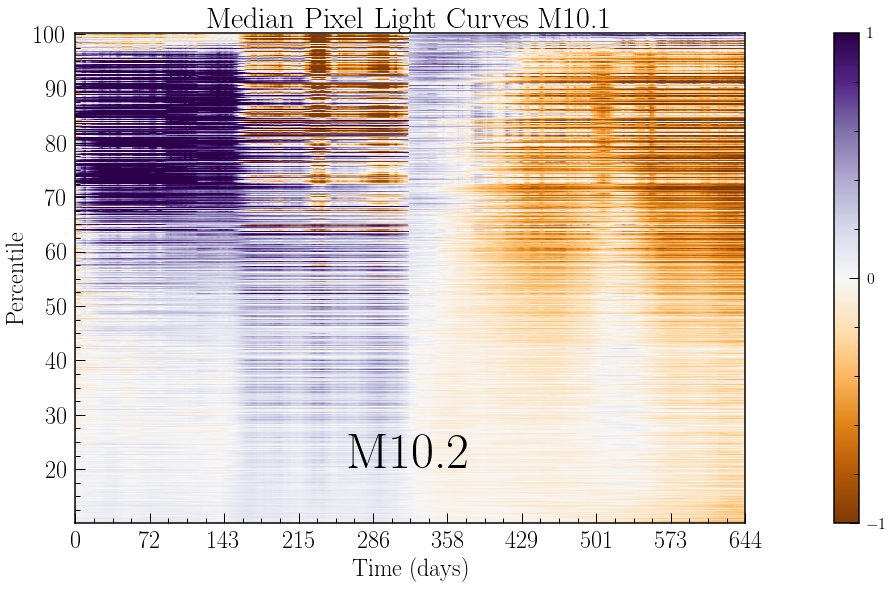

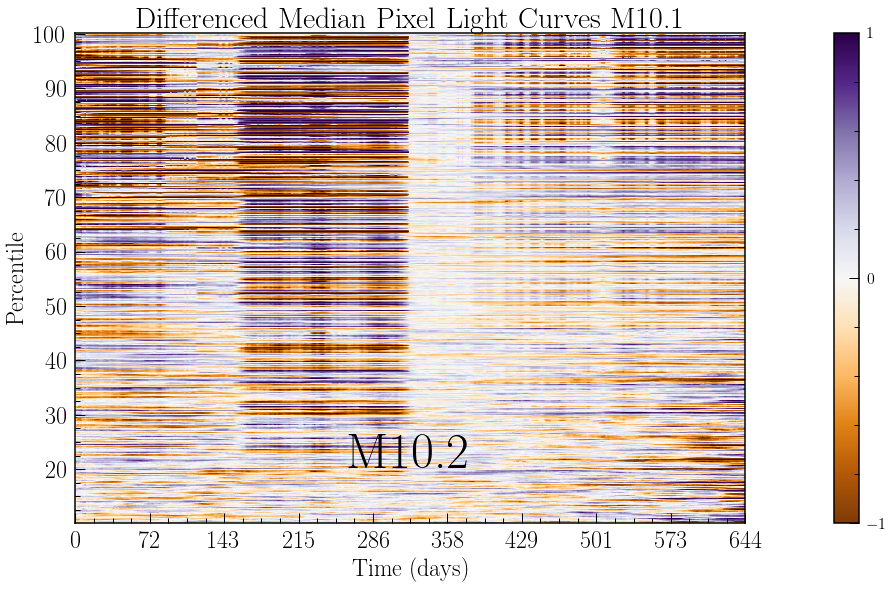

In [8]:
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,2], smooth=120, image=True,
                          aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapFull.png'.format(ccd.campaign, ccd.module, ccd.channel))
    
#Make the differenced image map
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,2], smooth=120, image=True,
                          differenced=True, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Differenced Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapDiff.png'.format(ccd.campaign, ccd.module, ccd.channel))
    